In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
#connect google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Copy of Copy of devnagari digit.zip"  # Change to your zip file path
extract_path = "/content/dataset"    # Change to where you want to unzip

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully.")

Unzipped successfully.


In [4]:
!pip install tree


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.2 MB/s eta 0:00:00
  Created wheel for tree: filename=Tree-0.2.4-py3-none-any.whl size=7860 sha256=9d709948b32345ffcb3e9723fae09fd18dc479ad86df1f69afe2542d4c2638e3
  Stored in directory: /root/.cache/pip/wheels/e8/ed/fe/b4c6a9b7a5b8df6d966ea673e26a46a7451b020af754eafa6b
Successfully built tree


In [5]:
!tree -d /content/dataset/DevanagariHandwrittenDigitDataset

/bin/bash: line 1: tree: command not found


In [6]:
# Define dataset paths
train_dir = "/content/dataset/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/dataset/DevanagariHandwrittenDigitDataset/Test"

print("Dataset path loaded")

# Create a function to load and preprocess the dataset
def load_dataset(data_dir):
    images = []
    labels = []
    class_mapping = {}

    # Get the list of digit classes
    classes = sorted(os.listdir(data_dir))

    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)

        if not os.path.isdir(class_dir):
            continue

        class_mapping[class_idx] = class_name
        print(f"Loading class {class_name} ({class_idx})")

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)

            # Load and preprocess the image
            try:
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize((28, 28))  # Resize to 28x28
                img_array = np.array(img) / 255.0  # Normalize to 0-1

                # Flatten the image to a 1D array
                img_array = img_array.flatten()

                images.append(img_array)
                labels.append(class_idx)

            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # Convert labels to one-hot encoded format
    y_one_hot = to_categorical(y, num_classes=len(classes))

    return X, y_one_hot, len(classes), class_mapping



Dataset path loaded


In [7]:
# Load training data
print("Loading training dataset...")
x_train, y_train, num_classes, class_mapping = load_dataset(train_dir)

# Load test data
print("\nLoading test dataset...")
x_test, y_test, _, _ = load_dataset(test_dir)

# Print dataset information
print(f"\nTraining data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {class_mapping}")

Loading training dataset...
Loading class digit_0 (0)
Loading class digit_1 (1)
Loading class digit_2 (2)
Loading class digit_3 (3)
Loading class digit_4 (4)
Loading class digit_5 (5)
Loading class digit_6 (6)
Loading class digit_7 (7)
Loading class digit_8 (8)
Loading class digit_9 (9)

Loading test dataset...
Loading class digit_0 (0)
Loading class digit_1 (1)
Loading class digit_2 (2)
Loading class digit_3 (3)
Loading class digit_4 (4)
Loading class digit_5 (5)
Loading class digit_6 (6)
Loading class digit_7 (7)
Loading class digit_8 (8)
Loading class digit_9 (9)

Training data shape: (17000, 784)
Training labels shape: (17000, 10)
Test data shape: (3000, 784)
Test labels shape: (3000, 10)
Number of classes: 10
Class mapping: {0: 'digit_0', 1: 'digit_1', 2: 'digit_2', 3: 'digit_3', 4: 'digit_4', 5: 'digit_5', 6: 'digit_6', 7: 'digit_7', 8: 'digit_8', 9: 'digit_9'}


# Add Noise and Visualize Data.

In [8]:
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)

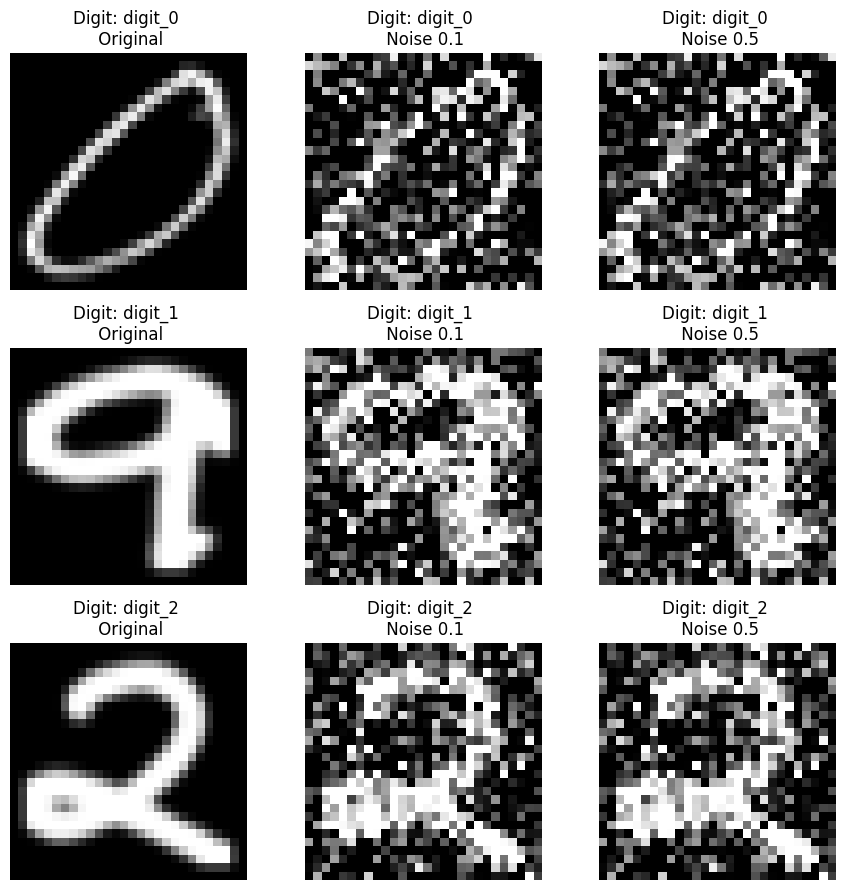

In [9]:
# Clip values to be in the range [0, 1]
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)

# Visualize in a 3 x 3 grid
n = 3  # number of images to show
plt.figure(figsize=(9, 9))

for i in range(n):
    # Find an image of digit i
    indices = [idx for idx, label in enumerate(np.argmax(y_train, axis=1)) if label == i]

    if indices:
      idx = indices[0]
      # Original image
      ax = plt.subplot(n, 3, i * 3 + 1)
      plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
      plt.title(f"Digit: {class_mapping[i]} \n Original")
      plt.axis('off')

      # Low noise image
      ax = plt.subplot(n, 3, i * 3 + 2)
      plt.imshow(x_train_noisy_high[idx].reshape(28, 28), cmap='gray')
      plt.title(f"Digit: {class_mapping[i]} \n Noise 0.1")
      plt.axis('off')

      # High noise image
      ax = plt.subplot(n, 3, i * 3 + 3)
      plt.imshow(x_train_noisy_high[idx].reshape(28, 28), cmap='gray')
      plt.title(f"Digit: {class_mapping[i]} \n Noise 0.5")
      plt.axis('off')

plt.tight_layout()
plt.show()

# Building Encoder

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras import Model

def build_encoder(input_shape=(28, 28, 1)):
    """
    Builds the encoder part of the convolutional autoencoder.

    Parameters:
        input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.

    Returns:
        input_img (Keras Input): Input layer of the model.
        encoded (Keras Tensor): Encoded representation after convolution and pooling.
    """
    input_img = Input(shape=input_shape, name="input")
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)

    return input_img, encoded


# Building Decoder


In [11]:
from tensorflow.keras.layers import Conv2D, UpSampling2D

def build_decoder(encoded_input):
    """
    Builds the decoder part of the convolutional autoencoder.

    Parameters:
        encoded_input (Keras Tensor): The output from the encoder.

    Returns:
        decoded (Keras Tensor): The reconstructed output after upsampling and convolution.
    """
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
    return decoded


# Building Autoencdoder

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_autoencoder():
    """
    Constructs and compiles the full convolutional autoencoder by connecting encoder and decoder.

    Returns:
        autoencoder (Keras Model): Compiled autoencoder model.
    """
    input_img, encoded_output = build_encoder()
    decoded_output = build_decoder(encoded_output)
    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder


# Compile the Model

In [13]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

# Train Autoencoder

In [14]:
# Training Autoencoder

x_train = x_train.reshape(-1, 28, 28, 1)
x_train_noisy_high = x_train_noisy_high.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_test_noisy_high = x_test_noisy_high.reshape(-1, 28, 28, 1)

# Build the autoencoder from previous steps
autoencoder = build_autoencoder()

# Train with noisy input and clean target
history = autoencoder.fit(
    x_train_noisy_high, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_high, x_test)
)


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.4337 - val_loss: 0.2179
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2134 - val_loss: 0.2025
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2016 - val_loss: 0.1956
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1957 - val_loss: 0.1923
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1921 - val_loss: 0.1898
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1895 - val_loss: 0.1880
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1880 - val_loss: 0.1887
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1868 - val_loss: 0.1858
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1856 - val_loss: 0.1858
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1853 - val_loss: 0.1839


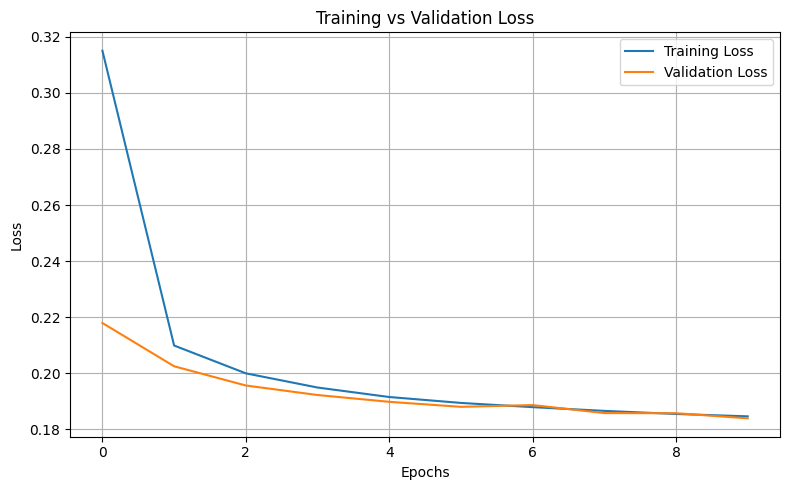

In [23]:
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call this after training
plot_loss(history)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


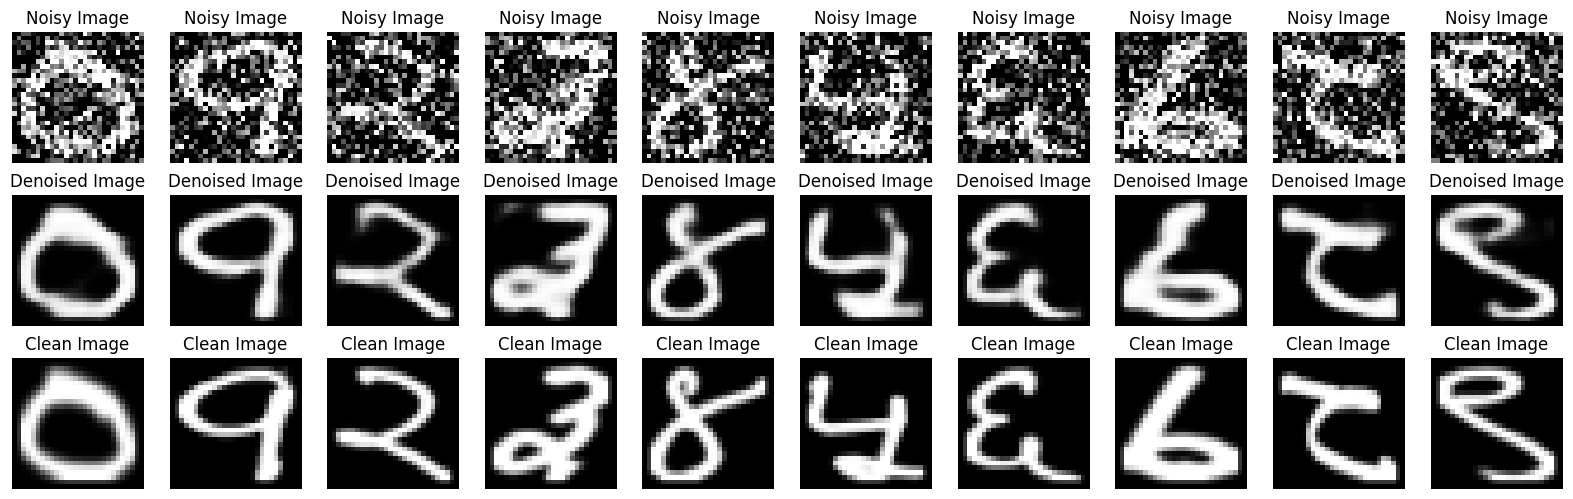

In [22]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)

# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Find an image of digit i in the test dataset
        indices = [idx for idx, label in enumerate(np.argmax(y_test, axis=1)) if label == i] # Use y_test here instead of y_train

        if indices:
          idx = indices[0]
          # Plot noisy images
          plt.subplot(3, n, i + 1)
          plt.imshow(noisy_images[idx].reshape(28, 28), cmap='gray')
          plt.title("Noisy Image")
          plt.axis('off')

          # Plot denoised images
          plt.subplot(3, n, i + 1 + n)
          plt.imshow(denoised_images[idx].reshape(28, 28), cmap='gray')
          plt.title("Denoised Image")
          plt.axis('off')

          # Plot clean images
          plt.subplot(3, n, i + 1 + 2 * n)
          plt.imshow(clean_images[idx].reshape(28, 28), cmap='gray')
          plt.title("Clean Image")
          plt.axis('off')

    plt.show()

# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)